# Structure

## Bitrate

`bitrate[name][projection][tiling][tile][quality][chunk]['dash_m4s']: int`

or

`bitrate[name][projection][tiling][tile][quality]['dash_init']: int`

or

`bitrate[name][projection][tiling][tile]['dash_mpd']: int`

In [2]:
import json
from collections import defaultdict
from dataclasses import dataclass
from functools import reduce
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.core.interchange.dataframe_protocol import DataFrame


In [3]:
# Paths
graphs_workfolder = Path('../graphs/bitrate')
database_path = Path('../dataset/bitrate')

In [4]:
@dataclass
class Config:
    dataset_file = "dataset/nasrabadi.json"

    duration = 60,
    fps = 30,
    gop = 30,
    scale = "3240x2160"

    rate_control = "qp",
    decoding_num = 5,

    bins = 30,
    metric_list = ["time", "rate", "ssim", "mse", "s-mse", "ws-mse"],
    error_metric = "rmse",
    distributions = ["burr12", "fatiguelife", "gamma", "beta", "invgauss",
                     "rayleigh", "lognorm", "genpareto", "pareto", "halfnorm",
                     "expon"],

    fov = "110x90",

    chunk_list = list(map(str, range(1, 61)))
    quality_list = ["22", "28", "34", "40", "46", "50"]
    tiling_list = {"1x1": list(map(str, range(1))),
                   "3x2": list(map(str, range(6))),
                   "6x4": list(map(str, range(24))),
                   "9x6": list(map(str, range(54))),
                   "12x8": list(map(str, range(96)))}
    projection_list = ['cmp']
    name_list = {
        "angel_falls": {
            "offset": "5:30",
            "group": "MN"
        },
        "blue_angels": {
            "offset": "1:00",
            "group": "MM"
        },
        "cable_cam": {
            "offset": "0:15",
            "group": "HS"
        },
        "chariot_race": {
            "offset": "0:00",
            "group": "HM"
        },
        "closet_tour": {
            "offset": "0:07",
            "group": "FS"
        },
        "drone_chases_car": {
            "offset": "2:11",
            "group": "MS"
        },
        "drone_footage": {
            "offset": "0:01",
            "group": "HN"
        },
        "drone_video": {
            "offset": "0:15",
            "group": "VM"
        },
        "drop_tower": {
            "offset": "1:11",
            "group": "VM"
        },
        "dubstep_dance": {
            "offset": "0:05",
            "group": "FM"
        },
        "elevator_lift": {
            "offset": "0:00",
            "group": "VN"
        },
        "glass_elevator": {
            "offset": "0:14",
            "group": "VN"
        },
        "montana": {
            "offset": "0:00",
            "group": "FN"
        },
        "motorsports_park": {
            "offset": "0:15",
            "group": "HS"
        },
        "nyc_drive": {
            "offset": "0:12",
            "group": "HM"
        },
        "pac_man": {
            "offset": "0",
            "group": "MM"
        },
        "penthouse": {
            "offset": "0:04",
            "group": "RS"
        },
        "petite_anse": {
            "offset": "0:45",
            "group": "HN"
        },
        "rhinos": {
            "offset": "0:18",
            "group": "FM"
        },
        "sunset": {
            "offset": "0:40",
            "group": "FN"
        },
        "three_peaks": {
            "offset": "0:00",
            "group": "MN"
        },
        "video_04": {
            "offset": "0",
            "group": "FS"
        },
        "video_19": {
            "offset": "0",
            "group": "RN"
        },
        "video_20": {
            "offset": "0",
            "group": "RN"
        },
        "video_22": {
            "offset": "0",
            "group": "RS"
        },
        "video_23": {
            "offset": "0",
            "group": "RM"
        },
        "video_24": {
            "offset": "0",
            "group": "RM"
        },
        "wingsuit_dubai": {
            "offset": "0:00",
            "group": "MS"
        }
    }

    def get_tile_list(self, tiling):
        return self.tiling_list[tiling]


In [5]:
# Config
config = Config()

In [6]:
# utils
def get_nested_value(data, keys):
    """
    Fetch value from nested dict using a list of keys.
    :param data:
    :type data: dict
    :param keys:
    :type keys: list
    :return: Any
    """
    func = lambda d, key: d[key]
    try:
        return reduce(func, keys, data)
    except KeyError as e:
        raise KeyError(f"Key not found: {e}")
    except TypeError as e:
        raise TypeError(f"Invalid structure: {e}")
    
def set_nested_value(data, keys, value):
    subtree = get_nested_value(data, keys[:-1])
    subtree[keys[-1]] = value
    
class AutoDict(dict):
    def __missing__(self, key):
        self[key] = type(self)()
        return self[key]

def get_value(video_dict, metric):
    keys = []
    if metric == 'dash_mpd':
        keys = [name, projection, tiling, tile, 'dash_mpd']
    elif metric == 'dash_init':
        keys = [name, projection, tiling, tile, quality, 'dash_init']
    elif metric == 'dash_m4s':
        keys = [name, projection, tiling, tile, quality, chunk, 'dash_m4s']

    value = get_nested_value(video_dict, keys)
    return value


def set_bucket_n2(bucket, video_dict, metric, quality):
    value = get_value(video_dict, metric)
    keys = [metric, quality]
    
    try:
        get_nested_value(bucket, keys).append(value)
    except AttributeError:
        set_nested_value(bucket, keys, [value])

# bucket2 = AutoDict()
# for name in config.name_list:
#     video_json = database_path / f'bitrate_{name}.json'
#     video_dict = json.loads(video_json.read_text())
# 
#     for projection in config.projection_list:
#         for tiling in config.tiling_list:
#             for tile in config.get_tile_list(tiling):
#                 set_bucket_n1(bucket2, video_dict, metric='dash_mpd')
#                 for quality in config.quality_list:
#                     set_bucket_n2(bucket2, video_dict, metric='dash_init', quality=quality)
#                     for chunk in config.chunk_list:
#                         set_bucket_n2(bucket2, video_dict, metric='dash_m4s', quality=quality)
#                         
# bucket3 = AutoDict()
# for name in config.name_list:
#     video_json = database_path / f'bitrate_{name}.json'
#     video_dict = json.loads(video_json.read_text())
# 
#     for projection in config.projection_list:
#         for tiling in config.tiling_list:
#             for tile in config.get_tile_list(tiling):
#                 set_bucket_n1(bucket, video_dict, metric='dash_mpd')
#                 for quality in config.quality_list:
#                     set_bucket_n1(bucket, video_dict, metric='dash_init', quality=quality)
#                     for chunk in config.chunk_list:
#                         set_bucket_n1(bucket, video_dict, metric='dash_m4s', quality=quality)


In [7]:
def set_bucket(bucket, video_dict, metric):
    value = get_value(video_dict, metric)
    keys = [metric]
    
    try:
        get_nested_value(bucket, keys).append(value)
    except AttributeError:
        set_nested_value(bucket, keys, [value])


bucket = AutoDict()
for name in config.name_list:
    video_json = database_path / f'bitrate_{name}.json'
    video_dict = json.loads(video_json.read_text())

    for projection in config.projection_list:
        for tiling in config.tiling_list:
            for tile in config.get_tile_list(tiling):
                set_bucket(bucket, video_dict, metric='dash_mpd')
                for quality in config.quality_list:
                    set_bucket(bucket, video_dict, metric='dash_init')
                    for chunk in config.chunk_list:
                        set_bucket(bucket, video_dict, metric='dash_m4s')
print(bucket.keys())

dash_mpd_len = len(bucket['dash_mpd'])
dash_init_len = len(bucket['dash_init'])
dash_m4s_len = len(bucket['dash_m4s'])

print(f'{dash_mpd_len=}, {dash_init_len=}, {dash_m4s_len=}')


dict_keys(['dash_mpd', 'dash_init', 'dash_m4s'])
dash_mpd_len=5068, dash_init_len=30408, dash_m4s_len=1824480


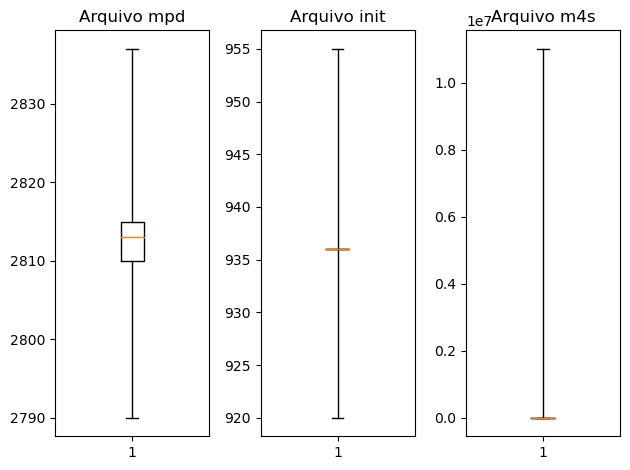

In [32]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.boxplot(bucket['dash_mpd'], whis=(0, 100))
ax1.title.set_text('Arquivo mpd')
ax2.boxplot(bucket['dash_init'], whis=(0, 100))
ax2.title.set_text('Arquivo init')
ax3.boxplot(bucket['dash_m4s'], whis=(0, 100))
ax3.title.set_text('Arquivo m4s')
fig.tight_layout()

In [41]:
from collections import defaultdict
tabela = defaultdict(list)
tabela['Nome'].append('MPD')
tabela['Média'].append(np.average(bucket['dash_mpd']))
tabela['Desvio Padrão'].append(np.std(bucket['dash_mpd']))
tabela['Mínimo'].append(np.quantile(bucket['dash_mpd'], 0))
tabela['1º Quartil'].append(np.quantile(bucket['dash_mpd'], 0.25))
tabela['Mediana'].append(np.quantile(bucket['dash_mpd'], 0.5))
tabela['3º Quartil'].append(np.quantile(bucket['dash_mpd'], 0.75))
tabela['Máximo'].append(np.quantile(bucket['dash_mpd'], 1))
  
tabela['Nome'].append('Init')
tabela['Média'].append(np.average(bucket['dash_init']))
tabela['Desvio Padrão'].append(np.std(bucket['dash_init']))
tabela['Mínimo'].append(np.quantile(bucket['dash_init'], 0))
tabela['1º Quartil'].append(np.quantile(bucket['dash_init'], 0.25))
tabela['Mediana'].append(np.quantile(bucket['dash_init'], 0.5))
tabela['3º Quartil'].append(np.quantile(bucket['dash_init'], 0.75))
tabela['Máximo'].append(np.quantile(bucket['dash_init'], 1))
  
tabela['Nome'].append('m4s')
tabela['Média'].append(np.average(bucket['dash_m4s']))
tabela['Desvio Padrão'].append(np.std(bucket['dash_m4s']))
tabela['Mínimo'].append(np.quantile(bucket['dash_m4s'], 0))
tabela['1º Quartil'].append(np.quantile(bucket['dash_m4s'], 0.25))
tabela['Mediana'].append(np.quantile(bucket['dash_m4s'], 0.5))
tabela['3º Quartil'].append(np.quantile(bucket['dash_m4s'], 0.75))
tabela['Máximo'].append(np.quantile(bucket['dash_m4s'], 1))

import pandas as pd

tabela_df:pd.DataFrame = pd.DataFrame(tabela)
tabela_df.to_csv('bitrate_stats.csv', index=False)

In [47]:
print(len((bucket['dash_mpd'])),len((bucket['dash_init'])),len((bucket['dash_m4s'])))
import numpy as np
print(np.sum([len((bucket['dash_mpd'])), len((bucket['dash_init'])), len((bucket['dash_m4s']))]))


5068 30408 1824480
1859956


In [49]:
from collections import Counter
print(Counter(bucket['dash_mpd']))
print(Counter(bucket['dash_init']))
# print(Counter(bucket['dash_m4s']))

Counter({2814: 645, 2815: 569, 2811: 531, 2813: 523, 2812: 438, 2810: 332, 2816: 319, 2809: 148, 2799: 139, 2808: 122, 2800: 106, 2798: 100, 2817: 94, 2819: 87, 2796: 85, 2807: 84, 2801: 70, 2795: 69, 2818: 64, 2797: 47, 2804: 44, 2802: 41, 2806: 36, 2793: 34, 2826: 32, 2794: 30, 2824: 28, 2820: 28, 2805: 25, 2825: 24, 2803: 21, 2830: 20, 2827: 20, 2823: 18, 2821: 17, 2828: 14, 2792: 14, 2829: 8, 2833: 7, 2831: 7, 2832: 6, 2822: 6, 2834: 5, 2790: 4, 2791: 4, 2837: 1, 2835: 1, 2836: 1})
Counter({936: 28236, 920: 1086, 955: 1086})


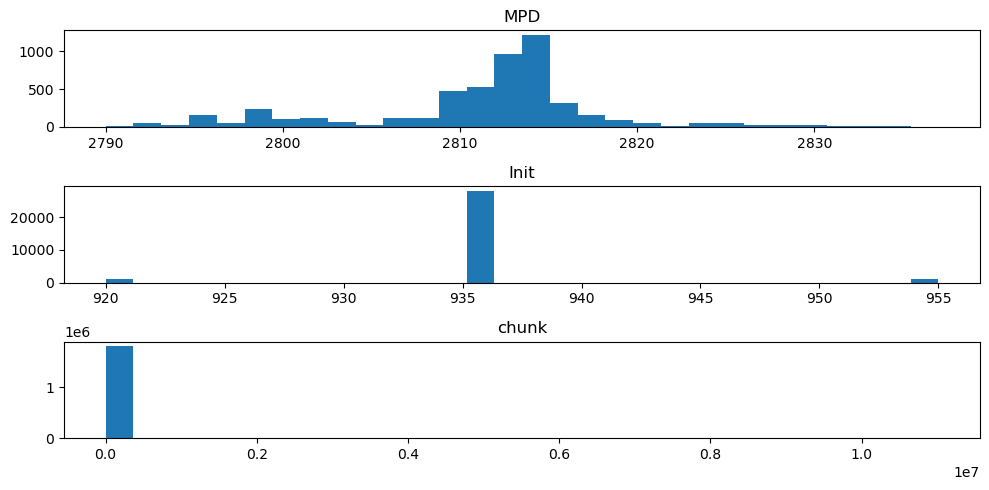

In [52]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
ax1.hist(bucket['dash_mpd'], bins=30)
ax1.set_title('MPD')
ax2.hist(bucket['dash_init'], bins=30)
ax2.set_title('Init')
ax3.hist(bucket['dash_m4s'], bins=30)
ax3.set_title('chunk')
fig.tight_layout()

Counter({2814: 645, 2815: 569, 2811: 531, 2813: 523, 2812: 438, 2810: 332, 2816: 319, 2809: 148, 2799: 139, 2808: 122, 2800: 106, 2798: 100, 2817: 94, 2819: 87, 2796: 85, 2807: 84, 2801: 70, 2795: 69, 2818: 64, 2797: 47, 2804: 44, 2802: 41, 2806: 36, 2793: 34, 2826: 32, 2794: 30, 2824: 28, 2820: 28, 2805: 25, 2825: 24, 2803: 21, 2830: 20, 2827: 20, 2823: 18, 2821: 17, 2828: 14, 2792: 14, 2829: 8, 2833: 7, 2831: 7, 2832: 6, 2822: 6, 2834: 5, 2790: 4, 2791: 4, 2837: 1, 2835: 1, 2836: 1})
Counter({936: 28236, 920: 1086, 955: 1086})
